In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
run="run_ab"

In [10]:
sc = xr.open_dataset("/home/disk/eos15/smturbev/DPSCREAM_simulations/dpscream_small_3km/{}/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(run,run[-2:]))
# sc = sc.isel(time=slice(-10,-1))
sce = sc.isel(time=slice(-10,-1)).mean(dim=["time"])# last time step # last ten days: (time=slice(-10,-1)).mean(dim=["time"]) 
sci = sc.isel(time=0) # first time step

## input file
iop = xr.open_dataset("../run_scripts/Cheyenne/RCE_iopfile_4scam.nc")
# sci = xr.open_dataset("../run_scripts/Cheyenne/cami_mam3_Linoz_ne30np4_SCREAM_L128_c160214.nc")
# iop = iop.isel(time=0).sel(lat=0).sel(lon=0)
print(sc["T"].shape, sce["T"].shape, sci["T"].shape)

(71, 128, 1296) (128, 1296) (128, 1296)


1 10
11 20
21 30
31 40
41 50
51 60
61 70


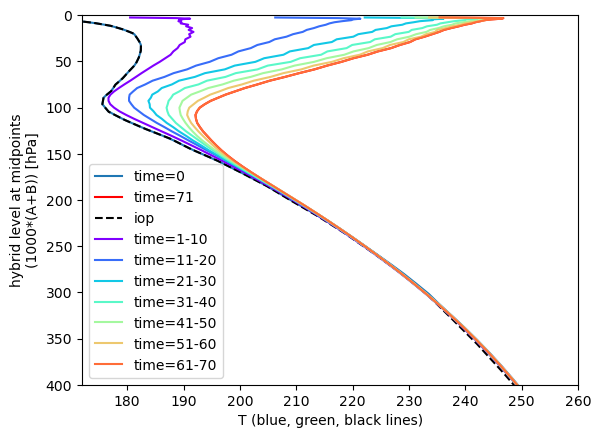

saved as plots/initial_condition_iop_comp_T.png


In [8]:
# plot temperature/wv (T/Q) profiles
vsc="T"
vio="T"
fig, ax = plt.subplots(1,1)
sci_mean = sci[vsc].mean(dim=["ncol"])
sce_mean = sce[vsc].mean(dim=["ncol"])
#time=0
sci_mean.plot(y="lev", label="time=0", ax=ax, color="C0")
#time=-1 last timestep
sce_mean.plot(y="lev", label="time={}".format(len(sc.time)), ax=ax, color="red")
#iop
ax.plot(iop[vio], iop.lev/100, linestyle="dashed", label="iop", 
        color="k")

cmap=mcm.get_cmap('rainbow')

for i in range(len(sc.time)//10):
    # plot 10 days averages from start to end
    print(1+(10*i),10+(10*i))
    sc_plot10days = sc[vsc].isel(time=slice(1+(10*i),10+(10*i))).mean(dim=["time","ncol"])
    ci = cmap(i/(len(sc.time)//10))
    sc_plot10days.plot(y="lev", label="time={}-{}".format(1+(10*i),10+(10*i)), 
                       ax=ax, color=ci)

## difference stuff
# axt = ax.twiny()
#difference in percent between sc initial timestep and iop file
# sci_interp = sci_mean.interp(lev=(iop.lev.values/100), method="linear")
# diff = (sci_interp-iop[vio].values)
# diff_mean = diff/sci_interp*100
# # diff.plot(y="lev", label="diff", 
# #           color="k", ax=ax, alpha=0.5, linewidth=0.5, marker=".")
# diff_mean.plot(y="lev", label="(sc_initial - iop)/sc_initial * 100", color="red", 
#                ax=axt,linewidth=0.5)
# #difference in percent between sc initial and end timesteps
# diff = (sci_mean-sce_mean)
# diff_mean = diff/sci_mean*100
# # diff.plot(y="lev", label="diff", 
# #           color="k", ax=ax, alpha=0.5, linewidth=0.5, marker=".")
# diff_mean.plot(y="lev", label="(sc_initial - sc_end)/sc_initial * 100", color="orange", 
#                ax=axt, linewidth=0.5)

# axis stuff
ax.legend(loc="lower left")
# axt.legend(loc="upper right")
# axt.set_xlabel("percent difference (red & orange lines)")
ax.set_xlabel(vsc+" (blue, green, black lines)")
ax.set_ylim([400,0])
if vsc=="T":
    ax.set_xlim([172,260]) # for temp
else:
    ax.set_xlim([1e-8,1e-3]) # for wv
    ax.set_xscale("log")     # for wv

#save and show plot
save_name="plots/initial_condition_iop_comp_{}.png".format(vsc)
plt.savefig(save_name)
plt.show()
print("saved as",save_name)

In [24]:
sce.lev[-1].values, iop.lev[-1].values

(array(998.49642944), array(99849.64, dtype=float32))

In [14]:
iop[var_new].shape, np.repeat(new_temp[np.newaxis,:,np.newaxis,np.newaxis], 2, axis=0).shape

((2, 72, 1, 1), (2, 72, 1, 1))

<xarray.Dataset>
Dimensions:  (lon: 1, lat: 1, lev: 72, time: 2)
Coordinates:
  * lon      (lon) float32 0.0
  * lat      (lat) float32 0.0
  * lev      (lev) float32 12.38 18.28 26.99 ... 9.862e+04 9.938e+04 9.985e+04
Dimensions without coordinates: time
Data variables: (12/13)
    tsec     (time) int32 ...
    bdate    int32 ...
    Ps       (time, lat, lon) float32 ...
    Tg       (time, lat, lon) float32 ...
    Ptend    (time, lat, lon) float32 ...
    phis     (time, lat, lon) float32 ...
    ...       ...
    q        (time, lev, lat, lon) float32 ...
    u        (time, lev, lat, lon) float32 ...
    v        (time, lev, lat, lon) float32 ...
    omega    (time, lev, lat, lon) float32 ...
    divT     (time, lev, lat, lon) float32 ...
    divq     (time, lev, lat, lon) float32 ...
Attributes:
    description:  Forcing for GABLS


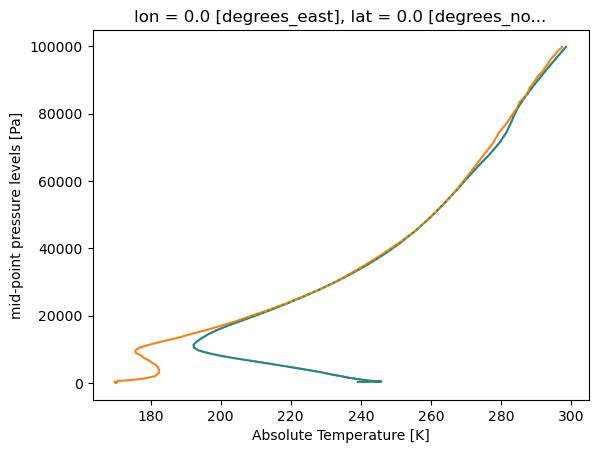

In [20]:
# # save last 10 day mean temp profile to new iop file
# var="Q"
# var_new="q"
# new_temp = sce[var].interp(lev=iop.lev.values/100, 
#                            method="linear").mean(dim="ncol").values.astype("float32")
# print(new_temp.shape, type(new_temp))
# # make new dataarray with dim from iop file
# print(iop[var_new].dims, iop[var_new].coords, iop[var_new].attrs)
# da = xr.DataArray(np.repeat(new_temp[np.newaxis,:,np.newaxis,np.newaxis], 2, axis=0), 
#                   dims=iop[var_new].dims, 
#                   coords=iop[var_new].coords, 
#                   attrs=iop[var_new].attrs)
# iop_new = iop.assign({var_new:da})
# print(iop_new)
# # check it looks right
# plt.plot(new_temp, iop_new.lev.values/100, label="interp lev", marker=".")
# plt.plot(iop[var_new][0,:,0,0], iop_new.lev.values/100, label="iop0")
# plt.plot(iop[var_new][1,:,0,0], iop_new.lev.values/100, label="iop1", linestyle="dashed")
# sce[var].mean(dim="ncol").plot(y="lev", label="full "+var, linestyle="dotted")
# plt.ylim([1000,0])
# plt.legend()
# plt.show()
# # save iop with new temp profile
# iop_new.to_netcdf("../run_scripts/Cheyenne/RCE_iopfile_4scam_new{}.nc".format(var_new))
# print("saved {}".format(var_new))


## save both T and q new profiles
iop_t = xr.open_dataset("../run_scripts/Cheyenne/RCE_iopfile_4scam_newT.nc").T
iop_newq = xr.open_dataset("../run_scripts/Cheyenne/RCE_iopfile_4scam_newq.nc")
iop_newTq = iop_newq.assign({"T":iop_t})
print(iop_newTq)
# check its different
iop_t[0,:,0,0].plot(y="lev")
iop_newq.T[0,:,0,0].plot(y="lev")
iop_newTq.T[0,:,0,0].plot(y="lev", linestyle="dotted") 
plt.show()
iop_newTq.to_netcdf("../run_scripts/Cheyenne/RCE_iopfile_4scam_newTq.nc")

In [45]:
# def function to calculate RHice from xarray
def rh_ice(ds, varQ="Q", varT="T", z_units="hPa"):
    """ input: xarray with variables Q and T
        output: xarray of rh wrt ice
    """
    e_si = np.exp(9.550426 - 5723.265/ds[varT] \
                  + 3.53068*np.log(ds[varT]) - 0.00728332*ds[varT])
    if z_units=="hPa":
        z = ds.lev*100
    else:
        z=ds.lev
    w_si = (0.622 * e_si) / (z - e_si)
    w_i  = ds[varQ] / (1 - ds[varQ])
    rh_ice = w_i/w_si * 100
    return rh_ice

In [46]:
rh_run = rh_ice(sc)
rh_iop = rh_ice(iop, varQ="q", z_units="Pa")
print(rh_run.shape, rh_iop.shape)

(71, 128, 1296) (72,)


1 10
11 20
21 30
31 40
41 50
51 60
61 70


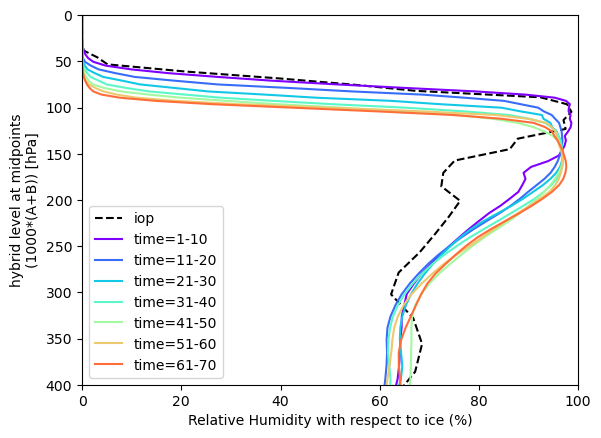

In [50]:
fig, ax = plt.subplots(1,1)

# plot iop
ax.plot(rh_iop, iop.lev/100, linestyle="dashed", label="iop", 
        color="k")

cmap=mcm.get_cmap('rainbow')
for i in range(len(sc.time)//10):
    # plot 10 days averages from start to end
    print(1+(10*i),10+(10*i))
    sc_plot10days = rh_run.isel(time=slice(1+(10*i),10+(10*i))).mean(dim=["time","ncol"])
    ci = cmap(i/(len(sc.time)//10))
    sc_plot10days.plot(y="lev", label="time={}-{}".format(1+(10*i),10+(10*i)), 
                       ax=ax, color=ci)
# axis stuff
ax.legend(loc="lower left")
ax.set_xlabel("Relative Humidity with respect to ice (%)")
ax.set_ylim([400,0])
ax.set_xlim([0,100]) # for wv

#save and show plot
save_name="plots/initial_condition_iop_comp_rhice.png"
plt.savefig(save_name)
plt.show()

In [70]:
da = abs(sc["T"].mean(dim=["time","ncol"])-273)
print(da.shape)
frz = np.argmin(da.values)
print(frz, da[frz].lev.values)

(128,)
84 633.7692260742189


In [64]:
frz

<xarray.DataArray 'T' (lev: 128)>
array([-53.551453 , -42.66356  , -40.879135 , -42.63878  , -42.917145 ,
       -44.324814 , -45.233963 , -46.209793 , -46.666443 , -47.943115 ,
       -48.65132  , -50.059296 , -50.466064 , -52.158142 , -53.00615  ,
       -55.101562 , -55.92099  , -58.195007 , -59.292206 , -61.747375 ,
       -62.992218 , -65.69458  , -67.40752  , -70.33911  , -72.165695 ,
       -75.02295  , -76.89801  , -79.428665 , -81.05281  , -83.02576  ,
       -84.17815  , -85.34035  , -85.94612  , -86.53856  , -86.73074  ,
       -86.86188  , -86.59444  , -86.22389  , -85.534256 , -84.77463  ,
       -83.806015 , -82.814316 , -81.68326  , -80.506195 , -79.206696 ,
       -77.8712   , -76.41037  , -74.83945  , -73.116714 , -71.34752  ,
       -69.51747  , -67.61461  , -65.617065 , -63.60318  , -61.582    ,
       -59.524536 , -57.40271  , -55.254395 , -53.123398 , -50.979935 ,
       -48.77797  , -46.539215 , -44.325516 , -42.12935  , -39.89328  ,
       -37.63623  , -35.409058 , -33.23581  , -31.061035 , -28.880112 ,
       -26.73552  , -24.660477 , -22.609879 , -20.561249 , -18.539413 ,
       -16.595947 , -14.700104 , -12.803375 , -10.909058 ,  -9.059784 ,
        -7.2889404,  -5.5601807,  -3.8892212,  -2.1975098,  -0.5787964,
         1.1979675,   2.941742 ,   4.5738525,   6.051544 ,   7.3280334,
         8.388184 ,   9.239471 ,   9.916687 ,  10.491852 ,  11.045349 ,
        11.624359 ,  12.261017 ,  12.943024 ,  13.572388 ,  14.11264  ,
        14.59256  ,  15.066193 ,  15.540955 ,  16.01007  ,  16.474976 ,
        16.94104  ,  17.404419 ,  17.861206 ,  18.312195 ,  18.7594   ,
        19.202911 ,  19.63971  ,  20.067627 ,  20.48996  ,  20.910309 ,
        21.3208   ,  21.718933 ,  22.108887 ,  22.49405  ,  22.867401 ,
        23.223907 ,  23.569122 ,  23.907654 ,  24.233337 ,  24.54309  ,
        24.854706 ,  25.19577  ,  25.521332 ], dtype=float32)
Coordinates:
  * lev      (lev) float64 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5